In [1]:
from Bio import SeqIO
from tqdm.notebook import tqdm
from collections import defaultdict

from utils.experiment_utils import get_all_experiments_info, load_checkpoint#load_best_model
import torch
import os
import hydra
from omegaconf import DictConfig, OmegaConf
from torch.utils.data import DataLoader

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from datasets.virus import ViralDataset

from collections import Counter

In [2]:
def load_model(cfg, path, device, ckpt=None):
    enc = hydra.utils.instantiate(cfg['encoder'])
    gen = hydra.utils.instantiate(cfg['generator'])
    if ckpt is not None:
        state = load_checkpoint(path, ckpt)
        enc.load_state_dict(state['encoder_state_dict'])
        gen.model.load_state_dict(state['generator_state_dict'])
    enc.eval()
    gen.model.eval()
    enc.to(device)
    gen.model.to(device)
    return enc, gen

def recursive_collate(batch_part):
            if isinstance(batch_part[0], torch.Tensor):
                return torch.stack(batch_part)
            elif isinstance(batch_part[0], dict):
                return {key: recursive_collate([b[key] for b in batch_part]) for key in batch_part[0]}
            else:
                return batch_part  # for strings, lists, or other non-tensor data
            


In [3]:
device = 'cuda'
configs = get_all_experiments_info('outputs/', False)
cfg = [c for c in configs if 'virus' in c['name'] 
       and c['config']['training']['save_interval']==1]
cfg = cfg[0]
cfg

cfg['config']['dataset']['tokenize'] = False
dataset = hydra.utils.instantiate(cfg['config']['dataset'])
enc, gen = load_model(cfg['config'], cfg['dir'], 'cuda', ckpt=3)
base_esm, _ = load_model(cfg['config'], cfg['dir'], 'cuda', ckpt=None)
# collated = recursive_collate([dataset.__getitem__(i) for i in range(3)])

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

dist_Zs = []
esm_mean_Zs = []
seq_Zs = []
TLs = []

break_after = 10**3

for i, batch in tqdm(enumerate(dataloader)):
    samples = batch['samples']
    seq = {}
    for k, v in samples.items():
        if isinstance(v, torch.Tensor):
            samples[k] = v.to('cuda')
            # seq[k] = v[:, :1, :].to('cuda')

    with torch.no_grad():
        latent = enc(samples)
        # seq_latent = base_esm(seq)

        b, s = samples['esm_input_ids'].shape[:2]
        ids = samples['esm_input_ids'].view(b * s, -1)
        mask = samples['esm_attention_mask'].view(b * s, -1)
        feats = base_esm.esm_extractor(ids, mask).view(b, s, -1)
        esm_mean = feats.mean(dim=1)
        seq_latent = feats[:, :1, :].squeeze(1)
        # esm_mean = base_esm(samples)

    dist_Zs.append(latent.cpu().numpy())
    seq_Zs.append(seq_latent.cpu().numpy())
    esm_mean_Zs.append(esm_mean.cpu().numpy())
    TLs.append(batch['time-loc'])

    if i > break_after:
        break

print(len(dist_Zs))
print(len(seq_Zs))
print(len(esm_mean_Zs))

T = np.array([item for sub in TLs for item in sub])
months = [t[:7] for t in T] # strings (yyyy-mm)
locs = [t.split('-')[-1] for t in T] # strings (country name)

0it [00:00, ?it/s]

1002
1002
1002


In [5]:
from datetime import datetime

# try parsing months safely to datetime
dates = []
for m in months:
    try:
        d = datetime.strptime(m, "%Y-%m")
        dates.append(d)
    except ValueError:
        dates.append(None)

start_date = datetime(2019, 12, 1)
# Convert dates to months since start_date
dates = [(d - start_date).days // 30 if d is not None else None for d in dates]

# drop None entries
valid = [i for i, d in enumerate(dates) if d is not None]

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.linear_model import Ridge
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Flatten dist_Zs and seq_Zs
dist_Zs_flat = np.vstack(dist_Zs)
seq_Zs_flat = np.vstack(seq_Zs)
esm_mean_Zs_flat = np.vstack(esm_mean_Zs)

# Encode months and locations
le_locs = LabelEncoder()
locs_encoded = le_locs.fit_transform(locs)

# Generate train-test split indices
train_inds, test_inds = train_test_split(np.arange(len(dist_Zs_flat)), test_size=0.5, random_state=42)

# Use the same indices for all datasets
X_train_dist, X_test_dist = dist_Zs_flat[train_inds], dist_Zs_flat[test_inds]
X_train_seq, X_test_seq = seq_Zs_flat[train_inds], seq_Zs_flat[test_inds]
X_train_esm, X_test_esm = esm_mean_Zs_flat[train_inds], esm_mean_Zs_flat[test_inds]

y_train_locs, y_test_locs = locs_encoded[train_inds], locs_encoded[test_inds]

# # Classification: Predict locations
# clf_dist = LinearSVC(max_iter=10000)
# clf_dist.fit(X_train_dist, y_train_locs)
# locs_pred_dist = clf_dist.predict(X_test_dist)
# accuracy_dist = accuracy_score(y_test_locs, locs_pred_dist)

# clf_seq = LinearSVC(max_iter=10000)
# clf_seq.fit(X_train_seq, y_train_locs)
# locs_pred_seq = clf_seq.predict(X_test_seq)
# accuracy_seq = accuracy_score(y_test_locs, locs_pred_seq)

# clf_esm = LinearSVC(max_iter=10000)
# clf_esm.fit(X_train_esm, y_train_locs)
# locs_pred_esm = clf_esm.predict(X_test_esm)
# accuracy_esm = accuracy_score(y_test_locs, locs_pred_esm)

# print(f"Location Classification Accuracy (dist_Zs): {accuracy_dist}")
# print(f"Location Classification Accuracy (seq_Zs): {accuracy_seq}")
# print(f"Location Classification Accuracy (esm_mean_Zs): {accuracy_esm}")


# Ensure valid indices for months
valid_train_inds = [i for i in train_inds if i in valid]
valid_test_inds = [i for i in test_inds if i in valid]

X_train_dist_valid, X_test_dist_valid = dist_Zs_flat[valid_train_inds], dist_Zs_flat[valid_test_inds]
X_train_seq_valid, X_test_seq_valid = seq_Zs_flat[valid_train_inds], seq_Zs_flat[valid_test_inds]
X_train_esm_valid, X_test_esm_valid = esm_mean_Zs_flat[valid_train_inds], esm_mean_Zs_flat[valid_test_inds]

y_train_months = [dates[i] for i in valid_train_inds]
y_test_months = [dates[i] for i in valid_test_inds]

# Regression
ridge_dist = Ridge(alpha=0.1)  # Adjust alpha as needed
ridge_dist.fit(X_train_dist_valid, y_train_months)
y_pred_dist = ridge_dist.predict(X_test_dist_valid)
mae_dist = mean_absolute_error(y_test_months, y_pred_dist)

ridge_seq = Ridge(alpha=0.1)  # Adjust alpha as needed
ridge_seq.fit(X_train_seq_valid, y_train_months)
y_pred_seq = ridge_seq.predict(X_test_seq_valid)
mae_seq = mean_absolute_error(y_test_months, y_pred_seq)

ridge_esm = Ridge(alpha=0.1)  # Adjust alpha as needed
ridge_esm.fit(X_train_esm_valid, y_train_months)
y_pred_esm = ridge_esm.predict(X_test_esm_valid)
mae_esm = mean_absolute_error(y_test_months, y_pred_esm)

print(f"Months Regression MAE (dist_Zs, Ridge): {mae_dist}")
print(f"Months Regression MAE (seq_Zs, Ridge): {mae_seq}")
print(f"Months Regression MAE (esm_mean_Zs, Ridge): {mae_esm}")

Months Regression MAE (dist_Zs, Ridge): 1.804907864759542
Months Regression MAE (seq_Zs, Ridge): 2.8934537119011328
Months Regression MAE (esm_mean_Zs, Ridge): 2.226662036629876


In [29]:
# Number of splits
n_splits = 10

# Store results
accuracy_dist_list = []
accuracy_seq_list = []
accuracy_esm_list = []

mae_dist_list = []
mae_seq_list = []
mae_esm_list = []

for _ in range(n_splits):
    # Generate train-test split indices
    train_inds, test_inds = train_test_split(np.arange(len(dist_Zs_flat)), test_size=0.5, random_state=None)

    # Use the same indices for all datasets
    X_train_dist, X_test_dist = dist_Zs_flat[train_inds], dist_Zs_flat[test_inds]
    X_train_seq, X_test_seq = seq_Zs_flat[train_inds], seq_Zs_flat[test_inds]
    X_train_esm, X_test_esm = esm_mean_Zs_flat[train_inds], esm_mean_Zs_flat[test_inds]

    y_train_locs, y_test_locs = locs_encoded[train_inds], locs_encoded[test_inds]

    # Classification: Predict locations
    clf_dist = LinearSVC(max_iter=10000)
    clf_dist.fit(X_train_dist, y_train_locs)
    locs_pred_dist = clf_dist.predict(X_test_dist)
    accuracy_dist_list.append(accuracy_score(y_test_locs, locs_pred_dist))

    clf_seq = LinearSVC(max_iter=10000)
    clf_seq.fit(X_train_seq, y_train_locs)
    locs_pred_seq = clf_seq.predict(X_test_seq)
    accuracy_seq_list.append(accuracy_score(y_test_locs, locs_pred_seq))

    clf_esm = LinearSVC(max_iter=10000)
    clf_esm.fit(X_train_esm, y_train_locs)
    locs_pred_esm = clf_esm.predict(X_test_esm)
    accuracy_esm_list.append(accuracy_score(y_test_locs, locs_pred_esm))

    # Ensure valid indices for months
    valid_train_inds = [i for i in train_inds if i in valid]
    valid_test_inds = [i for i in test_inds if i in valid]

    X_train_dist_valid, X_test_dist_valid = dist_Zs_flat[valid_train_inds], dist_Zs_flat[valid_test_inds]
    X_train_seq_valid, X_test_seq_valid = seq_Zs_flat[valid_train_inds], seq_Zs_flat[valid_test_inds]
    X_train_esm_valid, X_test_esm_valid = esm_mean_Zs_flat[valid_train_inds], esm_mean_Zs_flat[valid_test_inds]

    y_train_months = [dates[i] for i in valid_train_inds]
    y_test_months = [dates[i] for i in valid_test_inds]

    # Regression: Predict months with Ridge
    ridge_dist = Ridge(alpha=0.1)  # Adjust alpha as needed
    ridge_dist.fit(X_train_dist_valid, y_train_months)
    y_pred_dist = ridge_dist.predict(X_test_dist_valid)
    mae_dist = mean_absolute_error(y_test_months, y_pred_dist)
    mae_dist_list.append(mae_dist)

    ridge_seq = Ridge(alpha=0.1)  # Adjust alpha as needed
    ridge_seq.fit(X_train_seq_valid, y_train_months)
    y_pred_seq = ridge_seq.predict(X_test_seq_valid)
    mae_seq = mean_absolute_error(y_test_months, y_pred_seq)
    mae_seq_list.append(mae_seq)

    ridge_esm = Ridge(alpha=0.1)  # Adjust alpha as needed
    ridge_esm.fit(X_train_esm_valid, y_train_months)
    y_pred_esm = ridge_esm.predict(X_test_esm_valid)
    mae_esm = mean_absolute_error(y_test_months, y_pred_esm)
    mae_esm_list.append(mae_esm)

# Calculate mean and std for classification accuracies
print(f"Location Classification Accuracy (dist_Zs): Mean={np.mean(accuracy_dist_list):.4f}, Std={np.std(accuracy_dist_list):.4f}")
print(f"Location Classification Accuracy (seq_Zs): Mean={np.mean(accuracy_seq_list):.4f}, Std={np.std(accuracy_seq_list):.4f}")
print(f"Location Classification Accuracy (esm_mean_Zs): Mean={np.mean(accuracy_esm_list):.4f}, Std={np.std(accuracy_esm_list):.4f}")

# Calculate mean and std for regression MAEs
print(f"Months Regression MAE (dist_Zs, KernelRidge): Mean={np.mean(mae_dist_list):.4f}, Std={np.std(mae_dist_list):.4f}")
print(f"Months Regression MAE (seq_Zs, KernelRidge): Mean={np.mean(mae_seq_list):.4f}, Std={np.std(mae_seq_list):.4f}")
print(f"Months Regression MAE (esm_mean_Zs, KernelRidge): Mean={np.mean(mae_esm_list):.4f}, Std={np.std(mae_esm_list):.4f}")

Location Classification Accuracy (dist_Zs): Mean=0.2847, Std=0.0043
Location Classification Accuracy (seq_Zs): Mean=0.2295, Std=0.0104
Location Classification Accuracy (esm_mean_Zs): Mean=0.2524, Std=0.0109
Months Regression MAE (dist_Zs, KernelRidge): Mean=1.8270, Std=0.0302
Months Regression MAE (seq_Zs, KernelRidge): Mean=2.8930, Std=0.0409
Months Regression MAE (esm_mean_Zs, KernelRidge): Mean=2.2405, Std=0.0414


In [30]:
print("Train samples: %d" % len(X_train_dist))
print("Test samples: %d" % len(X_test_dist))
print("Train samples (valid): %d" % len(X_train_dist_valid))
print("Test samples (valid): %d" % len(X_test_dist_valid))
print("N splits: %d" % n_splits)

Train samples: 4008
Test samples: 4008
Train samples (valid): 4005
Test samples (valid): 4005
N splits: 10


In [34]:
from scipy.stats import sem
print(f"Location Classification Accuracy (dist_Zs): Mean = {np.mean(accuracy_dist_list):.4f} ± {sem(accuracy_dist_list):.4f}")
print(f"Location Classification Accuracy (seq_Zs): Mean = {np.mean(accuracy_seq_list):.4f} ± {sem(accuracy_seq_list):.4f}")
print(f"Location Classification Accuracy (esm_mean_Zs): Mean = {np.mean(accuracy_esm_list):.4f} ± {sem(accuracy_esm_list):.4f}")
print(f"Months Regression MAE (dist_Zs, Ridge): Mean = {np.mean(mae_dist_list):.4f} ± {sem(mae_dist_list):.4f}")
print(f"Months Regression MAE (seq_Zs, Ridge): Mean = {np.mean(mae_seq_list):.4f} ± {sem(mae_seq_list):.4f}")
print(f"Months Regression MAE (esm_mean_Zs, Ridge): Mean = {np.mean(mae_esm_list):.4f} ± {sem(mae_esm_list):.4f}")

Location Classification Accuracy (dist_Zs): Mean = 0.2847 ± 0.0014
Location Classification Accuracy (seq_Zs): Mean = 0.2295 ± 0.0035
Location Classification Accuracy (esm_mean_Zs): Mean = 0.2524 ± 0.0036
Months Regression MAE (dist_Zs, Ridge): Mean = 1.8270 ± 0.0101
Months Regression MAE (seq_Zs, Ridge): Mean = 2.8930 ± 0.0136
Months Regression MAE (esm_mean_Zs, Ridge): Mean = 2.2405 ± 0.0138


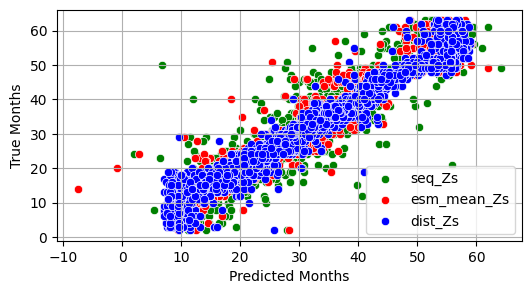

In [33]:
plt.figure(figsize=(6, 3))
sns.scatterplot(x=y_pred_seq, y=y_test_months, label='seq_Zs', color='green')
sns.scatterplot(x=y_pred_esm, y=y_test_months, label='esm_mean_Zs', color='red')
sns.scatterplot(x=y_pred_dist, y=y_test_months, label='dist_Zs', color='blue')

# Add labels, legend, and title
plt.xlabel('Predicted Months')
plt.ylabel('True Months')
plt.legend()
plt.grid(True)
plt.show()

In [38]:
np.unique(y_train_locs, return_counts=True)[1].max()/len(y_train_locs)

np.float64(0.21007984031936128)